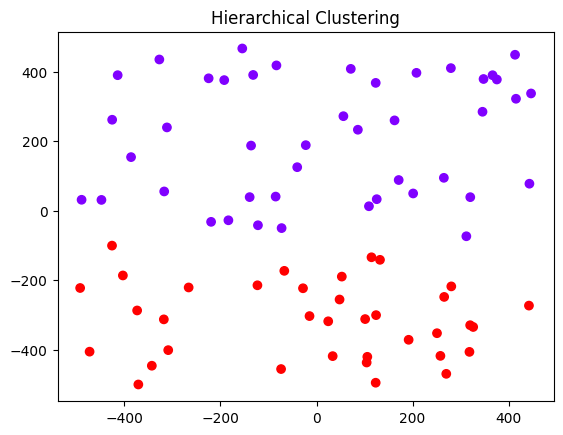

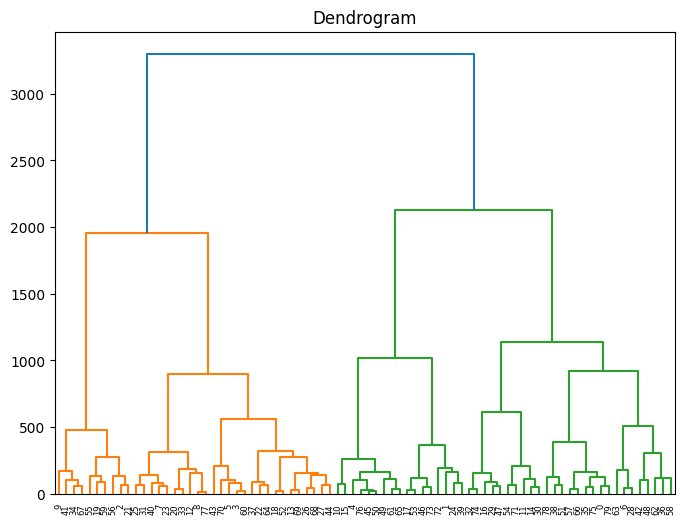

In [16]:
# Step 1: Import necessary libraries
import numpy as np
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from utils.classification_data import linear_data, checkerboard_data, power_line_data, microgrid_data, make_double_cake_data
from sklearn.model_selection import train_test_split

data = linear_data(2, 100)

## Extract features and target
features = np.asarray(data.drop(columns=['target']))
target = np.asarray(data['target'])
target = target % 2
target = 2 * target - 1

X, x_test, Y, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

# Step 2: Fit the hierarchical clustering model (use 'metric' instead of 'affinity')
model = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')
labels = model.fit_predict(X)

# Step 3: Visualize the clusters (optional)
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='rainbow')
plt.title("Hierarchical Clustering")
plt.show()

# Step 4: Plot the dendrogram (optional)
linked = linkage(X, method='ward')
plt.figure(figsize=(8, 6))
dendrogram(linked, orientation='top', distance_sort='ascending', show_leaf_counts=True)
plt.title('Dendrogram')
plt.show()

In [29]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib as mpl

np.random.seed(1359)
circuit_executions = 0
def layer(x, params, wires, i0=0, inc=1):
    """Building block of the embedding ansatz"""
    i = i0
    for j, wire in enumerate(wires):
        #qml.Hadamard(wires=[wire])
        qml.RZ(x[i % len(x)], wires=[wire])
        i += inc
        #qml.RY(params[0, j], wires=[wire])

    qml.broadcast(unitary=qml.CRZ, pattern="ring", wires=wires, parameters=params[1])

def ansatz(x, params, wires):
    """The embedding ansatz"""
    for j, layer_params in enumerate(params):
        layer(x, layer_params, wires, i0=j * len(wires))


adjoint_ansatz = qml.adjoint(ansatz)


def random_params(num_wires, num_layers):
    """Generate random variational parameters in the shape for the ansatz."""
    return np.random.uniform(0, 2 * np.pi, (num_layers, 2, num_wires), requires_grad=True)

dev = qml.device("default.qubit", wires=5, shots=None)
wires = dev.wires.tolist()

@qml.qnode(dev)
def kernel_circuit(x1, x2, params):
    global circuit_executions
    circuit_executions += 1
    ansatz(x1, params, wires=wires)
    adjoint_ansatz(x2, params, wires=wires)
    return qml.probs(wires=wires)

def kernel(x1, x2, params):
    return kernel_circuit(x1, x2, params)[0]


In [30]:
params = random_params(num_wires=5, num_layers=6)

In [31]:
kernel_value = kernel(X[0], X[1], params)
print(f"The kernel value between the first and second datapoint is {kernel_value:.3f}")

The kernel value between the first and second datapoint is 1.000


In [32]:
f_kernel = lambda x1, x2: kernel(x1, x2, params)
get_kernel_matrix = lambda x1, x2: qml.kernels.kernel_matrix(x1, x2, f_kernel)

In [33]:
kernel_matrix = get_kernel_matrix(X, X)

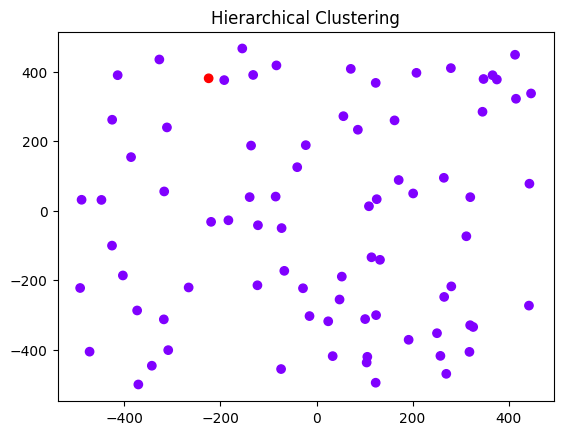

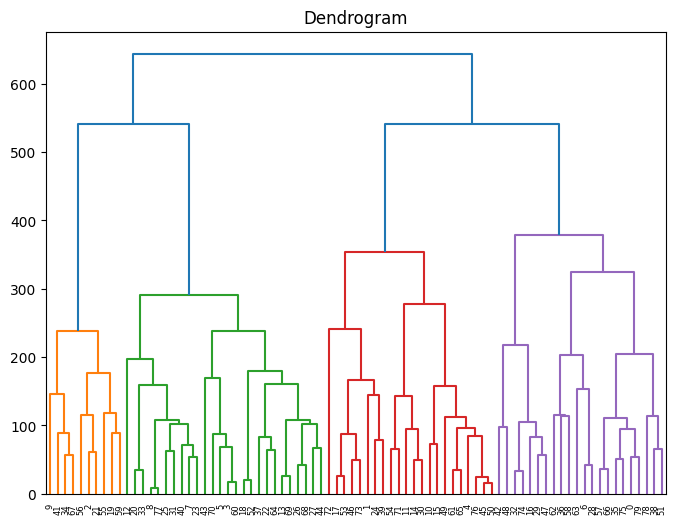

In [43]:
# Step 2: Fit the hierarchical clustering model (use 'metric' instead of 'affinity')
model = AgglomerativeClustering(n_clusters=2, metric='precomputed', linkage='average')
labels = model.fit_predict(kernel_matrix)

# Step 3: Visualize the clusters (optional)
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='rainbow')
plt.title("Hierarchical Clustering")
plt.show()

# Step 4: Plot the dendrogram (optional)
linked = linkage(X, method='average')
plt.figure(figsize=(8, 6))
dendrogram(linked, orientation='top', distance_sort='ascending', show_leaf_counts=True)
plt.title('Dendrogram')
plt.show()

In [47]:
# Step 2: Calculate the centroids manually
centroids = np.array([X[labels == i].mean(axis=0) for i in np.unique(labels)])

# Print the centroids for each cluster
for idx, centroid in enumerate(centroids):
    print(f"Centroid of cluster {idx}: {centroid}")

Centroid of cluster 0: [  9.50998267 -30.27079489]
Centroid of cluster 1: [-224.49309144  381.00192356]


In [48]:
import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import matplotlib.pyplot as plt
clusters_at_distance = fcluster(linked, t=10, criterion='distance')

# Step 4: Print the cluster labels for each point at the chosen hierarchy level
print("Cluster labels at distance threshold 6:")
print(clusters_at_distance)

# Step 5: Access clusters with a fixed number of clusters
# Example: If you want exactly 3 clusters, use criterion="maxclust"
clusters_with_k = fcluster(linked, t=2, criterion='maxclust')

# Print the cluster labels when forced into 3 clusters
print("Cluster labels with 3 clusters:")
print(clusters_with_k)

Cluster labels at distance threshold 6:
[75 42  5 20 56 22 68 16 13  4 49 48 19 30 46 50 64 36 25  8 11  6 27 17
 40 14 32 34 69 62 47 15 60 12  1 73 65 29 77 41 18  3 58 24 35 53 38 63
 59 57 54 78 26 37 44 10  7 71 66  9 21 51 67 70 28 52 72  2 33 31 23 45
 43 39 61 74 55 13 79 76]
Cluster labels with 3 clusters:
[2 2 1 1 2 1 2 1 1 1 2 2 1 1 2 2 2 2 1 1 1 1 1 1 2 1 1 1 2 2 2 1 2 1 1 2 2
 1 2 2 1 1 2 1 1 2 2 2 2 2 2 2 1 2 2 1 1 2 2 1 1 2 2 2 1 2 2 1 1 1 1 2 2 2
 2 2 2 1 2 2]
